In [1]:
import pandas as PD
import numpy as NP
import matplotlib.pyplot as PLT
from tqdm import tqdm as TQDM
from scipy.spatial.distance import cdist
from scipy.optimize import least_squares

In [2]:
class model:
    def variogram_exponential(d, pars):
        """Exponential model, pars[3] = [psill, range, nugget]
                              x     
                         - ( --- )  
                             [2]    
        y = [1] * ( 1 - e^        ) + [0]
        """
        psill = float(pars[0])
        prange = float(pars[1])
        nugget = float(pars[2])
        return psill * (1. - NP.exp(-d/(prange))) + nugget

In [40]:
class variogram:
    def __init__(self, lag, lag_min=0, lag_max=NP.inf, model=None):
        self.model = model
        self.lag = lag
        self.lag_min = lag_min
        self.lag_max = lag_max
        self.lags_edge = []
        self.lags_d = []
        self.lags_n = []
        self.lags_v = []
        self.fitted_parms = None
    
    def binned(self, X, y, batch_size=100, metric='euclidean'):
        """
        Calculate semi-variogram and make binned lags
        """
        X = NP.atleast_1d(X)
        y = NP.atleast_1d(y)
        n = y.shape[0]
        
        ## Make X, y two 2-D ##
        if X.ndim < 2: X = X[:, NP.newaxis]
        if y.ndim < 2: y = y[:, NP.newaxis]
        
        ## create batch index ##
        n_batch = int(n/batch_size)
        n_batch = n_batch + 1 if n_batch < n/batch_size else n_batch 

        ## calculate ##
        for i in range(n_batch):
            i = i*batch_size
            j = i + batch_size
            d = NP.triu(cdist(X[i:j, :], X[i:, :], metric=metric))
            v = NP.triu(cdist(y[i:j, :], y[i:, :], metric='sqeuclidean')/2)
            ## select distance in lag's range
            selection = (d > self.lag_min) & (d <= self.lag_max)
            d = d[selection]
            v = v[selection]
            ## binned lags ##
            nlags = int(max(d)/self.lag)
            nlags = nlags + 1 if nlags != 1 else nlags
            for b in range(nlags):
                edge = b*self.lag
                msk = (d >= edge) & (d < edge + self.lag)
                if edge in self.lags_edge:
                    self.lags_d[b] += sum(d[msk])
                    self.lags_n[b] += len(d[msk])
                    self.lags_v[b] += sum(v[msk])
                else:
                    self.lags_edge.append(edge)
                    self.lags_d.append(sum(d[msk]))
                    self.lags_n.append(len(d[msk]))
                    self.lags_v.append(sum(v[msk]))
                    
    @property
    def semivariograms(self):
        return NP.array(self.lags_v)/NP.array(self.lags_n)
    
    @property
    def lags(self):
        return NP.array(self.lags_d)/NP.array(self.lags_n)
        
    
    def partial_fit(self, X, y):
        X = NP.atleast_2d(X)
        y = NP.atleast_1d(y)
        
    
    def update_fit(self, model=None):
        if model is not None:
            self.update_model(model)
        ## Initialized parameters for fitting
        self.update_params()
        ## Fit with least square
        self.results = least_squares(fun=self._cost, x0=self.params, bounds=self.params_bound, loss='soft_l1') 
        self.params = self.results.x
    
    def _cost(self, params):
        cost = self.model(params, self.lags) - self.variances
        return cost
    
    def plot(self, to=None, title='', transparent=True, show=True):
        """Displays variogram model with the actual binned data."""
        fig, ax = PLT.subplots(figsize=PLT.gcf().get_size_inches())
        ax.plot(self.lags, self.semivariograms, 'k*')
        if self.fitted_parms is not None:
            ax.plot(self.lags, self.model(self.lags, self.fitted_parms), 'r-')
        PLT.title(title)
        if show:
            PLT.show()
        if to is not None:
            print('>> [INFO] Saving plot to %s'% to)
            PLT.savefig(to, transparent=transparent)

In [41]:
df = PD.read_csv('earth_tw.csv')
df.head()

,event,datetime,lon,lat,depth,intensity,station_id,station_name,station_lon,station_lat,distance,az,pga_v,pga_ns,pga_ew,d
0,0,2018-12-14 04:56:39,303898.534518,2.661770e+06,17.7,3.5,TWD,Xiulin,311007.912765,2.664013e+06,8.22,255.19,8.24,5.79,9.97,7455.018061
1,0,2018-12-14 04:56:39,303898.534518,2.661770e+06,17.7,3.5,ETM,Tongmen,299865.343998,2.651787e+06,11.26,17.81,27.06,53.78,37.68,10766.259718
2,0,2018-12-14 04:56:39,303898.534518,2.661770e+06,17.7,3.5,HWA,HualienCity,312072.754264,2.652942e+06,13.09,317.56,15.05,14.58,23.59,12030.634070
3,0,2018-12-14 04:56:39,303898.534518,2.661770e+06,17.7,3.5,ETL,Taroko,313002.380630,2.672882e+06,14.44,222.69,5.94,19.33,15.33,14365.702485
4,0,2018-12-14 04:56:39,303898.534518,2.661770e+06,17.7,3.5,ETLH,Xibao,298756.774779,2.678364e+06,16.64,164.09,6.89,8.04,8.54,17372.811019


In [67]:
VAR = variogram(10)
events = TQDM(df['event'].unique())
for evt in events:
    event = df.query('event == %d'%evt)
    X = event[['station_lon', 'station_lat']].values/1000
    y = event['pga_ew'].values
    VAR.binned(X, y)

100%|██████████| 58/58 [00:00<00:00, 374.43it/s]


<Figure size 720x360 with 0 Axes>

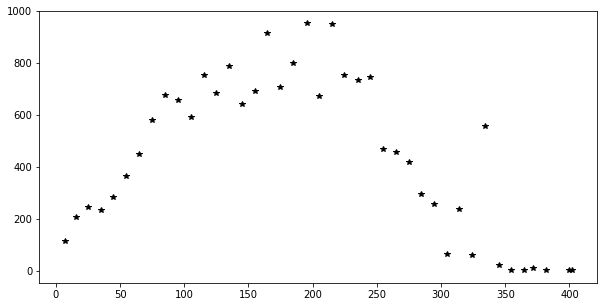

In [69]:
PLT.figure(figsize=[10,5])
VAR.plot()

In [ ]:
class variogram:
    def __init__(self, lag_range=None, lag_max=NP.inf, distance_type='euclidean', model='poly1', model_params=None, model_paramsbound=None, n_jobs=1, good_lowbin_fit=False, tqdm=False, debug=False):
        """
        distance_type : str, ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘wminkowski’, ‘yule’
        """
        self.tqdm = tqdm
        self.debug = debug
        self.nlags = 0
        self.good_lowbin_fit = good_lowbin_fit
        self.lags = NP.array([])
        self.variances = NP.array([])
        self.update_n_jobs(n_jobs)
        self.update_model(model)
        self.update_params(model_params, model_paramsbound)
        self.update_lag_range(lag_range)
        self.update_lag_max(lag_max)
        self.update_distance_type(distance_type)

    def update_lag_range(self, lag_range):        
        self.lag_range = lag_range

    def update_lag_max(self, lag_max):        
        self.lag_max = lag_max

    def update_distance_type(self, distance_type):
        """
        distance_type : str, ‘braycurtis’, ‘canberra’, ‘chebyshev’, ‘cityblock’, ‘correlation’, ‘cosine’, ‘dice’, ‘euclidean’, ‘hamming’, ‘jaccard’, ‘jensenshannon’, ‘kulsinski’, ‘mahalanobis’, ‘matching’, ‘minkowski’, ‘rogerstanimoto’, ‘russellrao’, ‘seuclidean’, ‘sokalmichener’, ‘sokalsneath’, ‘sqeuclidean’, ‘wminkowski’, ‘yule’
        """
        self.distance_type = distance_type

    def update_model(self, model):
        if type(model) is not str: 
            if callable(model):
                self.model_name = 'custom'
                self.model = model
        else:
            model = model.lower()
            if model not in distributions.keys():
                print('>> [ERROR] variogram model %s not found.'% model)
                print('           exist models: ', distributions.keys())
                return
                #sys.exit()
            else:
                self.model_name = model
                self.model = distributions[model]

    def update_n_jobs(self, n_jobs):
        self.n_jobs = int(n_jobs) if n_jobs >= 1 else 1

    def update_params(self, params=None, params_bound=None):
        self.params = params
        self.params_bound = params_bound
        if self.params is None:
            if len(self.variances) > 0 and len(self.lags) > 0:
                if self.model_name == 'poly1':
                    self.params = [(NP.amax(self.variances)-NP.amin(self.variances))/(NP.amax(self.lags)-NP.amin(self.lags)), NP.amin(self.variances)]
                    self.params_bound = ([0., 0.], [NP.inf, NP.amax(self.variances)])
                elif self.model_name == 'power':
                    self.params = [(NP.amax(self.variances)-NP.amin(self.variances))/(NP.amax(self.lags)-NP.amin(self.lags)), 1.1, NP.amin(self.variances)]
                    self.params_bound = ([0., 0.001, 0.], [NP.inf, 1.999, NP.amax(self.variances)])
                else:
                    self.params = [NP.amax(self.variances)-NP.amin(self.variances), 0.25*NP.amax(self.lags), NP.amin(self.variances)]
                    self.params_bound = ([0., 0., 0.], [10.*NP.amax(self.variances), NP.amax(self.lags), NP.amax(self.variances)])
            else:
                if self.debug: 
                    print('>> [INFO] called variogram.update_params: variogram.params and variogram.params_bound are set to None.')

        elif self.params_bound is None:
            self.params_bound = ([-NP.inf for _ in range(len(self.params))],
                                 [ NP.inf for _ in range(len(self.params))])
        else:
            if self.debug: 
                print('>> [INFO] initialized variogram.params and variogram.params_bound')
                print(self.params)
                print(self.params_bound)

    def get_params(self, deep=False):
        if deep:
            return self.results
        else:
            return self.params

    def fit(self, X, y):
        X = NP.atleast_1d(X)
        y = NP.atleast_1d(y)
        if len(X) != len(y):
            print(">> [ERROR] different size %di, %d"%(len(X), len(y)))
            raise
        ## binning
        isBinned = False
        if self.lag_range is not None:
            isBinned = True
            nbins = int(self.lag_max/self.lag_range) + 1
            bins = [self.lag_range*n for n in range(nbins)]
            self.lags = NP.zeros(nbins)
            self.variances = NP.zeros(nbins)
            self.nlags = NP.zeros(nbins)
            if self.debug:
                print('>> [INFO] variogram : %d bins, max bin %.2f'%(nbins, max(bins)))

        ## Set batch jobs
        print(">> [INFO] Calculating variances for %d...."% len(y))
        batches = create_batchrange( len(y), self.n_jobs )
        if self.tqdm: 
            batches = TQDM(batches)

        ip = 0 # for pairwise
        for ib in batches:
            if self.tqdm: 
                batches.set_description(">> ")
           
            if len(X.shape) == 1:
                d = cdist( X[ib[0]:ib[1], NP.newaxis], 
                           X[ip:, NP.newaxis], 
                           metric=self.distance_type)
            else:
                d = cdist( X[ib[0]:ib[1]], 
                           X[ip:], 
                           metric=self.distance_type)
            v = cdist( y[ib[0]:ib[1], NP.newaxis], 
                       y[ip:, NP.newaxis], 
                       metric='sqeuclidean')/2

            ## Update pariwise index
            ip = ib[1]

            ## selection
            v = v[(d > 0) & (d < self.lag_max)]
            d = d[(d > 0) & (d < self.lag_max)]

            ## Fill by bin
            if isBinned:
                for n in range(nbins-1):
                    binned = (d >= bins[n]) & (d<bins[n+1])
                    self.lags[n] += sum(d[binned])
                    self.variances[n] += sum(v[binned])
                    self.nlags[n] += len(d[binned])
            else:
                self.lags = NP.concatenate((self.lags, d))
                self.variances = NP.concatenate((self.variances, v))
                self.nlags += len(self.lags)

        if self.tqdm: 
            batches.close()

        ## Selection for binned fit
        if isBinned:
            ## exclue empty bin
            self.lags = self.lags[ self.nlags > 0 ]
            self.variances = self.variances[ self.nlags > 0 ] 
            self.nlags = self.nlags[ self.nlags > 0 ]
            ## calculate avg
            self.lags = self.lags/self.nlags
            self.variances = self.variances/self.nlags
            ## exclude nan bin
            self.lags = self.lags[~NP.isnan(self.variances)]
            self.variances = self.variances[~NP.isnan(self.variances)]
        
        ## Fit with self.model
        print('>> [INFO] Fitting variogram....')
        self.update_fit()

    def update_fit(self, model=None):
        if model is not None:
            self.update_model(model)
        ## Initialized parameters for fitting
        self.update_params()
        ## Fit with least square
        self.results = least_squares( fun=self._cost, x0=self.params, bounds=self.params_bound, loss='soft_l1') 
        self.params = self.results.x

    def predict(self, X):
        '''
        input X: distance 
        output varaince
        '''
        return self.model(self.params, X)

    def plot(self, to=None, title='', transparent=True, show=True):
        """Displays variogram model with the actual binned data."""
        fig = PLT.figure()
        ax = fig.add_subplot(111)
        ax.plot(self.lags, self.variances, 'k*')
        ax.plot(self.lags, self.model(self.params, self.lags), 'r-')
        PLT.title(title)
        if show:
            PLT.show()
        if to is not None:
            print('>> [INFO] Saving plot to %s'% to)
            PLT.savefig(to, transparent=transparent)

    def _cost(self, params):
        if self.good_lowbin_fit:
            drange = NP.amax(self.lags) - NP.amin(self.lags)
            k = 2.1972 / (0.1 * drange)
            x0 = 0.7 * drange + NP.amin(self.lags)
            weights = 1. / (1. + NP.exp(-k * (x0 - self.lags)))
            weights /= NP.sum(weights)
            cost = (self.model(params, self.lags) - self.variances) * weights
        else:
            cost = self.model(params, self.lags) - self.variances
        return cost